# Terceiro Trabalho de Introdução à Computação Visual

### Membros:

* Arthur Pontes Nader - 2019022294
* Luiz Philippe Pereira Amaral - 2018054575 
* Rita Rezende Borges de Lima - 2020065317

## Instalação de bibliotecas e módulos

In [1]:
!pip install seaborn
!pip install sklearn

In [2]:
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

2022-07-13 22:54:57.498540: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /mnt/c/Users/ritar/Documentos/UFMG/Quarto Periodo/Introdução a Computação Visual/venv_captcha/lib/python3.8/site-packages/cv2/../../lib64:
2022-07-13 22:54:57.498969: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Pré Processamento


Inicialmente declaramos duas funções de conversão, ```char_to_int(x)```, que dado um caractere __x__, retorna seu valor inteiro correspondente e a função contrária ```int_to_char(x)``` que dado um inteiro retorna seu respectivo caractere.

In [3]:
def char_to_int(x):
    return {"0" : 0, "1" : 1, "2" : 2, "3" : 3, "4" : 4, "5" : 5, "6" : 6, "7" : 7, "8" : 8, "9" : 9, \
     "A" : 10, "B" : 11, "C" : 12, "D" : 13, "E" : 14, "F" : 15, "G" : 16, "H" : 17, "I" : 18,        \
     "J" : 19, "K" : 20, "L" : 21, "M" : 22, "N" : 23, "O" : 24, "P" : 25, "Q" : 26, "R" : 27,        \
     "S" : 28, "T" : 29, "U" : 30, "V" : 31, "X" : 32, "W" : 33, "Y" : 34, "Z" : 35, "?": 36}[x]

def int_to_char(x):
    return {0 : "0", 1 : "1", 2 : "2", 3 : "3", 4 : "4", 5 : "5", 6 : "6", 7 : "7", 8: "8", 9: "9", \
     10 : "A", 11 : "B", 12 : "C", 13 : "D", 14 : "E", 15 : "F", 16 : "G", 17 : "H", 18 : "I",        \
     19 : "J", 20 : "K", 21 : "L", 22 : "M", 23 : "N", 24 : "O", 25 : "P", 26 : "Q", 27 : "R",        \
     28 : "S", 29 : "T", 30 : "U", 31 : "V", 32 : "X", 33 : "W", 34 : "Y", 35 : "Z", 36 : "?"}[x]

### Leitura de Dados 

Declaramos uma função ```get_labels()``` que tem como propósito ler um arquivo com o rótulo, e retornar este como uma lista de inteiros, para isso utiliza a função declarada previamente ```char_to_int()```.

In [4]:
def get_labels(idx):

    arq = open("CAPTCHA-10k/labels10k/" + f"{idx:06}" + ".txt", "r")
    line = arq.readline()
    arq.close()
    
    return [char_to_int(char) for char in line if char != "\n"]

Abaixo declaramos a função ```read_images()``` que tem como intuito ler as imagens e retorna-las inteiras.

In [5]:
def read_images(initial_range, final_range, dir_path):
        
    images = []
    for idx in range(initial_range, final_range):
        img_path = dir_path + "/" + f"{idx:06}" + ".jpg"      
        img = cv2.imread(img_path)
        images.append(img)
    
    return images

### Processamento da Imagem

Em ambas as funções a seguir realizamos o processamento da imagem recebida como parâmetro, em ```image_preprocessing(img_path)``` fazemos a leitura da imagem, convertemos para gray scale, fazemos a binarização e aplicamos um blur com a mediana dos pixeis. De posse dessa imagem a função ```separate_image_characters(img)``` corta a imagem em 6 "pedaços", um para cada caractere e retorna estes em uma lista.

In [6]:
def image_processing(img_path):
    
    img = cv2.imread(img_path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    bin_img = cv2.threshold(gray_img, 16, 255, cv2.THRESH_BINARY)[1]
    img_median = cv2.medianBlur(bin_img, 5)
    
    return img_median 

def separate_image_characters(img):
    
    characters = []
    
    for j in range(10, img.shape[1], 30):
        aux = img[:,j:j+30]
        aux = cv2.resize(aux,(40,40))
        aux = cv2.threshold(aux, 127, 255, cv2.THRESH_BINARY)[1]
        aux = aux/255
        characters.append(aux)
        
    return characters

Por fim implementamos o procedimento ```pre_processing(initial_range, final_range, dir_path)``` que para cada um dos arquivos faz sua leitura e chama as funções previamente implementadas e descritas.

In [7]:
def pre_processing(initial_range, final_range, dir_path):

    x, y = [], []
    for i in range(initial_range, final_range):
        
        labels = get_labels(i)
        
        img_path = dir_path + "/" + f"{i:06}" + ".jpg" 
        img = image_processing(img_path)
        img_characters = separate_image_characters(img)
       
        for idx in range(0, 6):
            x.append(img_characters[idx])
            y.append(labels[idx])
            
    return np.array(x, dtype=np.float32), np.array(y)

x_train, y_train = pre_processing(1, 8001, 'CAPTCHA-10k/treinamento')
x_val, y_val = pre_processing(8001, 9001, 'CAPTCHA-10k/validacao')  
x_test, y_test = pre_processing(9001, 10001, 'CAPTCHA-10k/teste')

Exemplos de dado:

Imagem 40x40


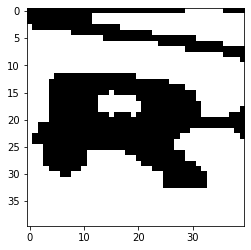

O rótulo é: R


In [8]:
num = 0
img = (x_train[num]*255)

print("Imagem {}x{}".format(len(img), len(img[0])))
plt.imshow(img, cmap='gray')
plt.show()

print("O rótulo é:", int_to_char(y_train[num]))

Imagem 40x40


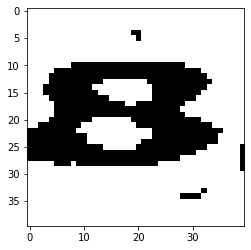

O rótulo é: 8


In [9]:
num = 78
img = (x_train[num]*255)

print("Imagem {}x{}".format(len(img), len(img[0])))
plt.imshow(img, cmap='gray')
plt.show()

print("O rótulo é:", int_to_char(y_train[num]))

## A Rede Neural Convolucional

### Definição da Arquitetura

Abaixo foi implementada a arquitetura para o classificador na função make_model(), para isso foram utilizadas camadas de convolução (3x3) e de Max Pooling (2x2). Para evitar um possível overfitting foi adicionada uma camada de Dropout. Em seguida a saída é transformada em um único vetor com Flatten e é passada para a camada densa com Dropout e ativação softmax que por sua vez fará a classificação.

In [35]:
def make_model(IMG_HEIGHT = 40, IMG_WIDTH = 40, NUMBER_OF_LABELS = 37):

    # Sequential layer
    model = Sequential()

    # CNN input layer
    model.add(Conv2D(32, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(IMG_HEIGHT,IMG_WIDTH, 1)))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))    

    # hiden layers
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))    
    model.add(Dropout(0.25))

    # fully connected layer
    model.add(Flatten())

    model.add(Dropout(0.5))
    model.add(Dense(NUMBER_OF_LABELS, activation='softmax'))

    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    return model

model = make_model()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 40, 40, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 20, 20, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 20, 20, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 10, 10, 32)        18464     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 5, 5, 32)        

### Treinamento

O treinamento da rede foi implementado com a função ```train_model()```, a quantidade de épocas e tamanho do batch serão parâmetros, mas como default são deixados como 3 e 128 respectivamente. É implementado um callback para terminar o treinamento quando for detectado que a acurácia da validação não está mais crescendo, é adicionada uma "paciência" de 2 épocas para tentar evitar máximos locais.

In [36]:
def train_model(model, NUMBER_OF_LABELS = 37, batch_size = 128, epochs = 3):

    response = model.fit(
            x_train, to_categorical(y = y_train, num_classes = NUMBER_OF_LABELS), 
            validation_data=(x_val, to_categorical(y_val, num_classes = NUMBER_OF_LABELS)),
            batch_size=batch_size, epochs=epochs, verbose=1,
        
            callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', patience=2)]
        )
    
    return model

Em seguida verificamos se existem modelos já treinados salvos localmente, a função descrita anteriormente é chamada com 15 épocas e batch size de tamanho 128 caso nenhum modelo previamente treinado tenha sido encontrado. 

In [37]:
batch_size = 256; epochs = 30
model_path = f'./model_batchSize_{batch_size}_epochs_{epochs}/'; model_file = 'saved_model.pb'

if  os.path.isfile(model_path + model_file):
    print('Um modelo treinado foi encontrado! Carregando Modelo...')   
    model = load_model(model_path)
    history = np.load(model_path +'my_history.npy', allow_pickle='TRUE').item()
    

else:   
    print('Trabalhando em um novo modelo...')
    train_model(model, batch_size = batch_size, epochs = epochs)
    model.save(model_path) 
    history = model.history.history
    np.save(model_path + 'my_history.npy', history)


Trabalhando em um novo modelo...
Epoch 1/30
188/188 [==============================] - 85s 447ms/step - loss: 1.4453 - accuracy: 0.5791 - val_loss: 0.3767 - val_accuracy: 0.8967
Epoch 2/30
188/188 [==============================] - 86s 459ms/step - loss: 0.5032 - accuracy: 0.8458 - val_loss: 0.2874 - val_accuracy: 0.9187
Epoch 3/30
188/188 [==============================] - 85s 451ms/step - loss: 0.3836 - accuracy: 0.8834 - val_loss: 0.2415 - val_accuracy: 0.9280
Epoch 4/30
188/188 [==============================] - 87s 464ms/step - loss: 0.3279 - accuracy: 0.9030 - val_loss: 0.2076 - val_accuracy: 0.9402
Epoch 5/30
188/188 [==============================] - 90s 478ms/step - loss: 0.2987 - accuracy: 0.9117 - val_loss: 0.1981 - val_accuracy: 0.9437
Epoch 6/30
188/188 [==============================] - 88s 468ms/step - loss: 0.2821 - accuracy: 0.9169 - val_loss: 0.1863 - val_accuracy: 0.9485
Epoch 7/30
188/188 [==============================] - 87s 464ms/step - loss: 0.2641 - accuracy: 0

INFO:tensorflow:Assets written to: ./model_batchSize_256_epochs_30/assets


INFO:tensorflow:Assets written to: ./model_batchSize_256_epochs_30/assets


In [38]:
history

{'loss': [1.4453046321868896,
  0.503206729888916,
  0.38358208537101746,
  0.3278603255748749,
  0.29872065782546997,
  0.2821253538131714,
  0.26412269473075867,
  0.2573412358760834,
  0.24964241683483124,
  0.23907765746116638],
 'accuracy': [0.5791041851043701,
  0.8457708358764648,
  0.8834375143051147,
  0.903041660785675,
  0.9117083549499512,
  0.9169166684150696,
  0.9232916831970215,
  0.9249791502952576,
  0.926520824432373,
  0.9301875233650208],
 'val_loss': [0.3766539990901947,
  0.28740376234054565,
  0.24149967730045319,
  0.2075956016778946,
  0.19807177782058716,
  0.1863323152065277,
  0.2006421536207199,
  0.18230010569095612,
  0.18299680948257446,
  0.19460250437259674],
 'val_accuracy': [0.8966666460037231,
  0.918666660785675,
  0.9279999732971191,
  0.9401666522026062,
  0.9436666369438171,
  0.9484999775886536,
  0.9443333148956299,
  0.9503333568572998,
  0.9474999904632568,
  0.9443333148956299]}

### Gráfico da Função de Perda - Validação e Treino

Utilizando-se do histórico do treinamento, é possível plotar os resultados intermediários para visualizarmos como a função de perda e a acurácia evoluiram ao longo das épocas.

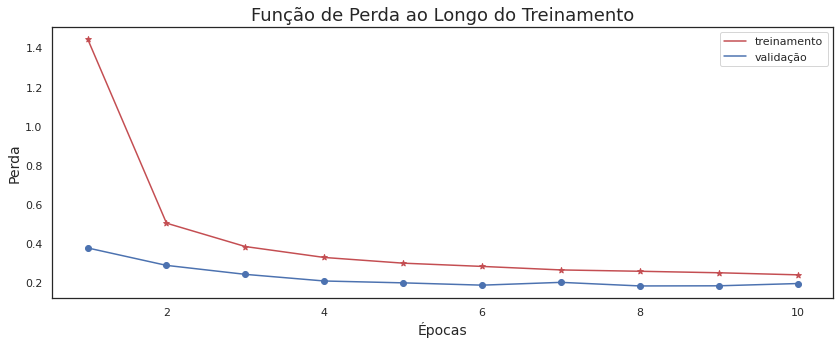

In [39]:
accuracy_values = history['accuracy']
loss_values = history['loss']
val_loss_values = history['val_loss']

epochs = range(1, len(accuracy_values) + 1)

plt.figure(figsize = (14,5))
plt.plot(epochs, loss_values, 'r', label='treinamento')
plt.plot(epochs, val_loss_values, 'b', label='validação')
plt.scatter(epochs, loss_values, c = 'r', marker = '*')
plt.scatter(epochs, val_loss_values, c = 'b')

plt.title('Função de Perda ao Longo do Treinamento', fontsize= 18)
plt.xlabel('Épocas', fontsize= 14)
plt.ylabel('Perda', fontsize= 14)
plt.legend()

plt.show()

### Gráfico da Acurácia - Validação e Treino

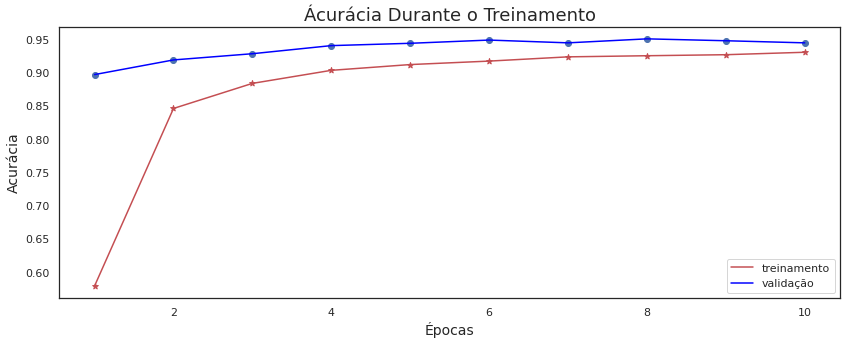

In [40]:
accuracy_values = history['accuracy']
valid_acc_values = history['val_accuracy']

plt.figure(figsize = (14,5))
plt.plot(epochs, accuracy_values, 'r', label='treinamento')
plt.plot(epochs, valid_acc_values, 'blue', label='validação')
plt.scatter(epochs, accuracy_values, c = 'r', marker = '*')
plt.scatter(epochs,valid_acc_values, c = 'b')

plt.title('Ácurácia Durante o Treinamento', fontsize= 18)
plt.xlabel('Épocas', fontsize= 14)
plt.ylabel('Acurácia', fontsize= 14)
plt.legend()

plt.show()

## Teste: Imagens e Suas Respectivas Classificações

Com o modelo devidamente treinado, podemos testar a rede neural com imagens nunca antes vistas. Para isso, a seguir iteramos em uma quantidade fixa de imagens de teste passadas por parâmetros com a função ```test_model_with_image()```. Esta chama para cada imagem a função ```predict_pic()``` que por sua vez faz a predição do modelo para as imagens passadas e chama as funções ```get_string_output()``` e ```transform_output()``` que transformam a saída da rede em uma string. Ao final plotamos a imagem e sua respectiva classificação.

In [41]:
def transform_output(char_pred):
    
    max_value = max(char_pred)
    idx = np.where(char_pred == max_value)
        
    return int_to_char(idx[0][0])

def get_string_output(img_pred):
    
    str_pred = ''
    for char_pred in img_pred:
        str_pred += transform_output(char_pred)
        
    return str_pred

def predict_pic(l_range, r_range):

    img_pred = model.predict(x_test[l_range:r_range])
    str_pred = get_string_output(img_pred)
    
    return str_pred
    
def test_model_with_image(max_displayed = 1000):
    
    imgs = read_images(9001, 9001 + max_displayed, 'CAPTCHA-10k/teste')
    
    print("Vamos mostrar {} imagens".format(max_displayed))
    
    for idx in range(0, max_displayed):
        l_range = 6 * idx; r_range = 6 * idx + 6
        str_pred = predict_pic(l_range, r_range)
        
        plt.imshow(imgs[idx], cmap='gray')
        plt.show()
       
        print("\t\t     ", str_pred)
        

Vamos mostrar 4 imagens
1/1 [==============================] - 0s 67ms/step


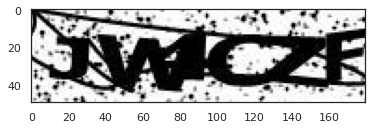

		      JW4CZF
1/1 [==============================] - 0s 21ms/step


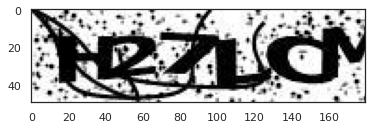

		      H27LCM
1/1 [==============================] - 0s 22ms/step


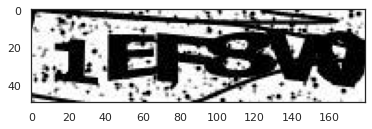

		      1EF8W0
1/1 [==============================] - 0s 20ms/step


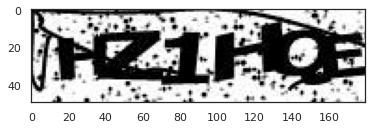

		      HZ1HQE


In [42]:
test_model_with_image(max_displayed = 4)

## Teste com Todas as Imagens

Abaixo a função ```test_model()``` realiza a predição de todas as imagens de teste para em seguida podermos calcular as métricas de sucesso da classificação. Acurárica, Predição, Revocação e F1.

In [43]:
def test_model(model, x_test, y_test):
    
    correct_predict_captcha = {"0": 0, "1": 0, "2": 0, "3": 0, "4": 0 , "5": 0, "6": 0}
    
    img_pred = model.predict(x_test.reshape(6000,40,40,1))
    label_pred = np.argmax(img_pred, axis = 1)
    results = label_pred == y_test
    
    for idx in range(0, len(results), 6):
        hits = np.sum(results[idx:idx+6])
        correct_predict_captcha[str(hits)] += 1
        
    return label_pred, correct_predict_captcha

### Avaliação dos resultados

Abaixo calculamos as métricas citadas anteriormente por meio da biblioteca __ScikitLearn__.

In [44]:
predictions, results_captcha = test_model(model, x_test, y_test)

accuracy = accuracy_score(y_test, predictions)
print(f"A acurácia obtida foi: {accuracy:.4f}")

188/188 [==============================] - 1s 6ms/step
A acurácia obtida foi: 0.9468


## Matriz de Confusão

Para obervarmos melhor os resultados obtidos e tentar identificar quais caracteres o classificador está confundindo, podemos gerar a matriz de confusão e visualizá-la utilizando uma função de plotagem baseada em mapa de calor presente na biblioteca __seaborn__. 

<AxesSubplot:>

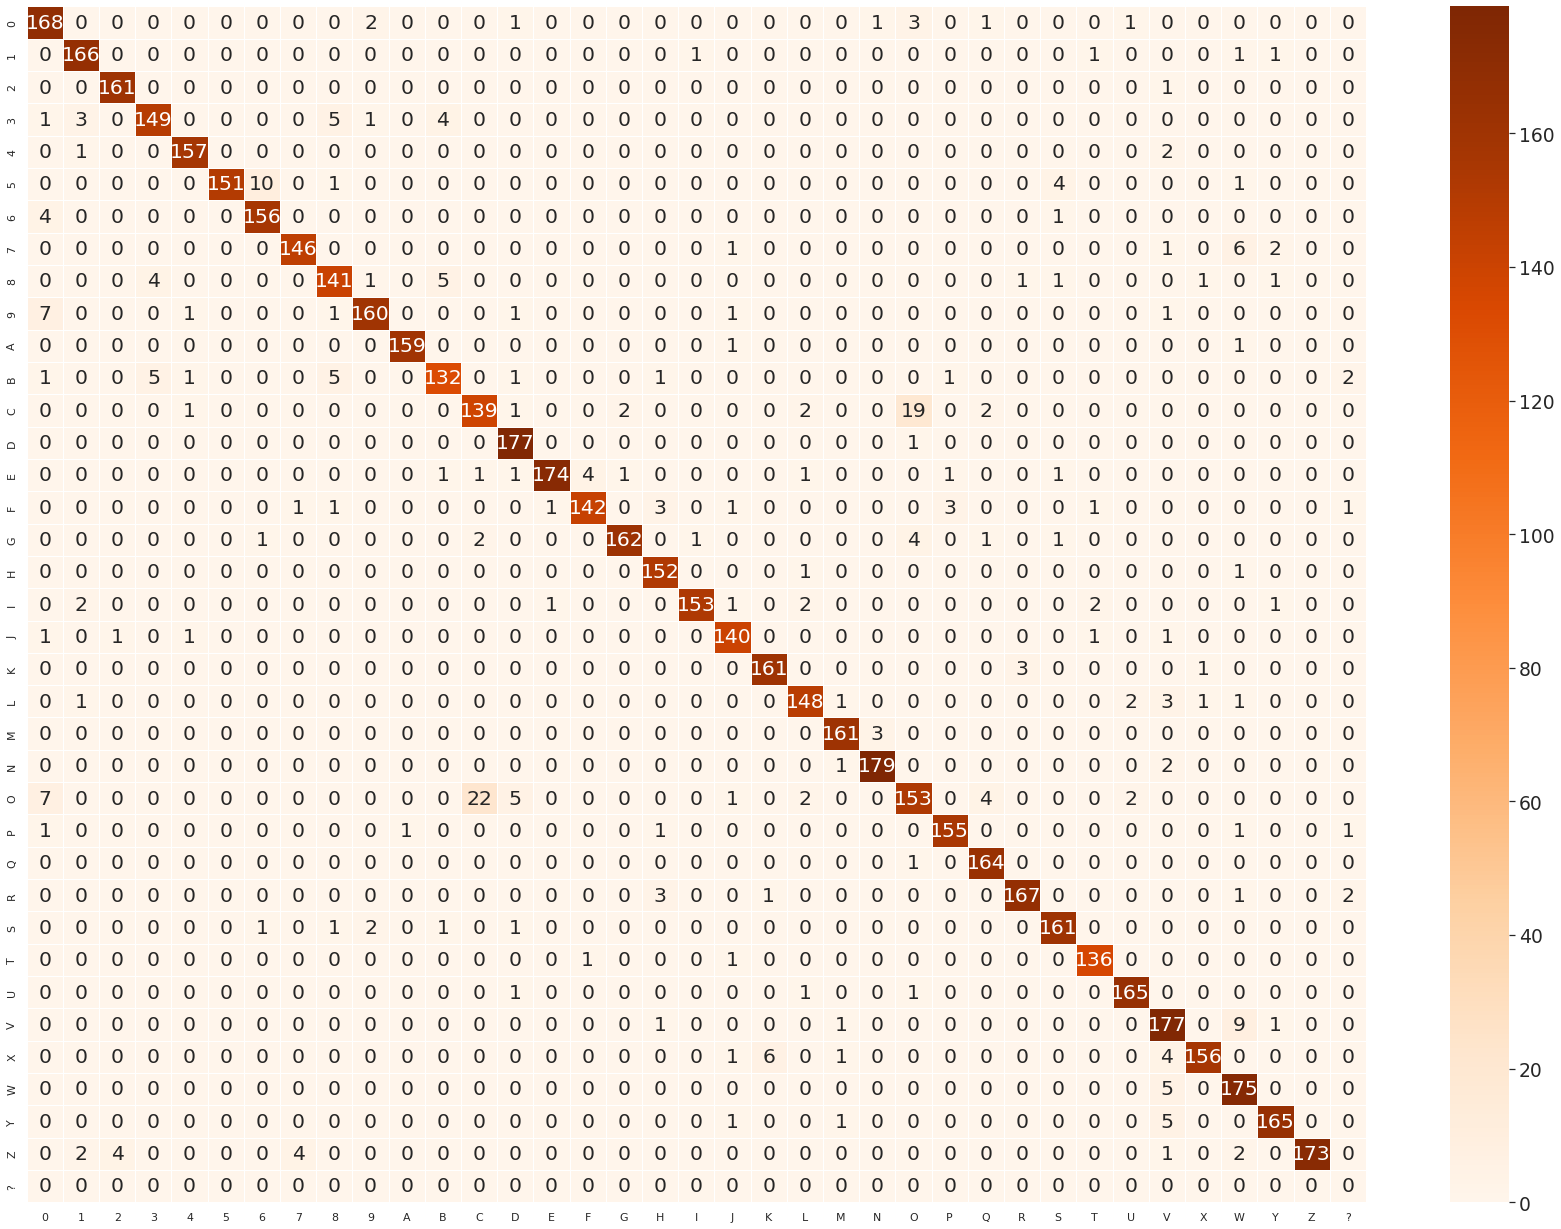

In [45]:
labels = ["0","1","2","3","4","5","6","7","8","9","A","B","C","D","E","F","G","H",\
          "I","J", "K","L","M","N","O","P","Q","R","S","T","U","V","X","W","Y","Z","?"]

conf_matrix = confusion_matrix(y_test, predictions)
_, axes = plt.subplots(figsize=(30,22))
sns.set(font_scale=1.7)
sns.heatmap(conf_matrix, annot=True, xticklabels = labels, 
            yticklabels = labels, linewidths=.5, ax=axes, cmap="Oranges", fmt='d')

## Acertos por Imagem

Com os resultados obtidos da predição, pode-se avaliar em quantos captchas nosso modelo conseguiu acertar todos os caracteres por meio de um histograma.

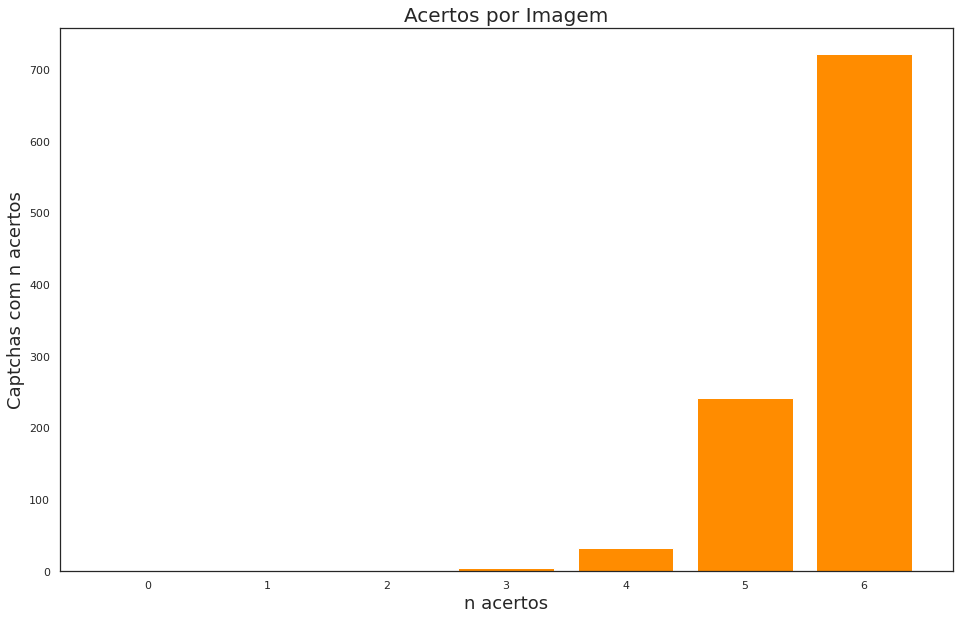

In [46]:
names = list(results_captcha.keys())
values = list(results_captcha.values())
sns.set_theme(style='white')

plt.figure(figsize = (16,10))
plt.title('Acertos por Imagem', fontsize = 20)
plt.xlabel('n acertos', fontsize = 18)

plt.ylabel('Captchas com n acertos', fontsize = 18)

plt.bar(range(len(results_captcha)), values, tick_label=names, color="darkorange")
plt.show()

In [ ]:
print()